In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


def gaussian3d(xy_range: tuple, z_range: tuple, mu: float, r0: float, z0: float) -> tuple:
    """
    Returns a tuple of four NumPy arrays representing the x, y, z, and intensity values of a 3D Gaussian ellipsoid.

    Parameters:
        xy_range (tuple): A tuple of two floats representing the minimum and maximum values for the x and y coordinates.
        z_range (tuple): A tuple of two floats representing the minimum and maximum values for the z coordinate.
        mu (float): The maximum intensity of the ellipsoid.
        r0 (float): The radius of the ellipsoid along the x and y axes.
        z0 (float): The radius of the ellipsoid along the z axis.

    Returns:
        tuple: A tuple of four NumPy arrays representing the x, y, z, and intensity values of the 3D Gaussian ellipsoid.

    """

    # Create a grid with good coverage using an empirical factor of 30
    xy_grid = np.linspace(*xy_range, int((xy_range[1] - xy_range[0]) * 30 + 1))
    z_grid = np.linspace(*z_range, int((z_range[1] - z_range[0]) * 30 + 1))
    x, y, z = np.meshgrid(xy_grid, xy_grid, z_grid)

    # Calculate the intensity values using a 3D Gaussian ellipsoid formula
    values = mu * np.exp(-2 * (x ** 2 + y ** 2) / r0 ** 2) * np.exp(-2 * z ** 2 / z0 ** 2)

    return x, y, z, values



def densityplot3d(ax: plt.axis, 
                  x: np.ndarray, 
                  y: np.ndarray, 
                  z: np.ndarray, 
                  values: np.ndarray, 
                  decay: float = 2.0,
                  opacity: float = 1.0, 
                  cmap: mpl.colors.LinearSegmentedColormap = plt.cm.jet,
                  **kwargs) -> None:
    """
    Create a density plot for X, Y, Z coordinates and corresponding intensity values.

    Parameters:
    -----------
    ax : plt.axis
        The axis object to plot the density plot on.
    x : np.ndarray
        An array of X-coordinates.
    y : np.ndarray
        An array of Y-coordinates.
    z : np.ndarray
        An array of Z-coordinates.
    values : np.ndarray
        An array of intensity values.
    decay : float, optional
        The decay factor for the alpha values. Default is 2.0.
    opacity : float, optional
        The opacity value for the alpha values. Default is 1.0.
    cmap : mpl.colors.LinearSegmentedColormap, optional
        The colormap used for mapping intensity values to RGB colors. Default is plt.cm.jet.
    **kwargs
        Additional keyword arguments to pass to the scatter function.

    Returns:
    --------
    None
    """

    # Calculate RGB colors from intensities
    # Normalize the intensities between 0 and 1 and convert them to RGB colors using the chosen colormap
    normed_values = values / np.max(values)
    colors = cmap(normed_values)
    
    # Create alpha values for each data point based on its intensity and the specified decay factor
    alphas = (values / np.max(values)) ** decay
    alphas *= opacity
    
    colors[:, :, :, 3] = alphas  # add alpha values to RGB values
    
    # Flatten color array but keep last dimension
    colors_flattened = colors.reshape(-1, colors.shape[-1])  

    # Plot a 3D scatter with adjusted alphas
    ax.scatter(x, y, z, c=colors_flattened, **kwargs)
    
    return None
    
    
    
def angular_mask(shape: tuple, centre: tuple, angle_range: tuple) -> np.ndarray:
    """Return a boolean mask for an angular sector.
    
    This function returns a boolean mask that can be used to select a circular sector
    in a 3D numpy array. The mask is created by defining a central point and an angular range,
    and setting all points in the array that lie within this range to True.
    
    Args:
        shape (tuple): A tuple specifying the shape of the 3D numpy array to be masked.
        centre (tuple): A tuple specifying the x, y coordinates of the central point of the sector.
        angle_range (tuple): A tuple specifying the angular range of the sector in degrees.
            The range should be specified as a tuple of two values (start_angle, stop_angle),
            where start_angle is the angle at which the sector begins, and stop_angle is the
            angle at which the sector ends. The sector extends clockwise from the start angle
            to the stop angle.
    
    Returns:
        A boolean mask that can be used to select a circular sector in a 3D numpy array.
        
    Adapted from community wiki's answer:
    https://stackoverflow.com/questions/18352973/mask-a-circular-sector-in-a-numpy-array
    """
    x, y = np.ogrid[:shape[0], :shape[1]]
    cx, cy = centre

    # Convert degrees to radians
    tmin, tmax = np.deg2rad(angle_range)

    # Ensure stop angle > start angle
    if tmax < tmin:
        tmax += 2 * np.pi

    theta = np.arctan2(x - cx, y - cy) - tmin

    # Wrap angles between 0 and 2*pi
    theta %= (2 * np.pi)

    # Angles as 3D shape
    theta3d = np.tile(theta, (shape[2], 1, 1)).T

    # Angular mask
    anglemask = theta3d <= (tmax - tmin)

    return anglemask

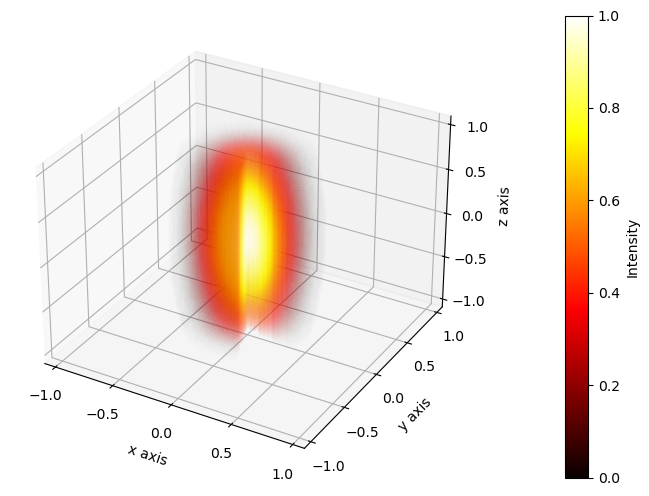

In [2]:
# Set up parameters for data generation
xy_range = (-1.0, 1.0)
z_range = (-1.0, 1.0)
mu = 1
r0 = 0.5
z0 = 1.6

# Set up parameters for plot display
opacity = 0.7
decay = 2.0
labels = ['x axis', 'y axis', 'z axis']
cmap = plt.cm.hot
markersize = 3

# Create figure and axis
fig = plt.figure(num=1, clear=True, figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Get data to plot
x, y, z, vals = gaussian3d(xy_range, z_range, mu, r0, z0)

# Optional slice window
centre = (vals.shape[0]//2, vals.shape[1]//2)
angular_window = (105, 160)
mask = angular_mask(vals.shape, centre, angular_window)
vals = np.where(~mask, vals, 0)

# Plot data
densityplot3d(ax, x, y, z, vals, cmap=cmap, opacity=opacity, decay=decay, s=markersize)

# Set up colorbar
cmap = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(np.min(vals), np.max(vals)), cmap=cmap)

# Add colorbar with labels and padding
fig.colorbar(cmap, ax=ax, label='Intensity', pad=0.1)

# Set labels and add padding
ax.set_xlabel(labels[0], labelpad=5)
ax.set_ylabel(labels[1], labelpad=5)
ax.set_zlabel(labels[2], labelpad=5)

# Set limits
adjuster = 1.05
ax.set_xlim([xy_range[0] * adjuster, xy_range[1] * adjuster])
ax.set_ylim([xy_range[0] * adjuster, xy_range[1] * adjuster])
ax.set_zlim([z_range[0] * adjuster, z_range[1] * adjuster])

# Adjust tick frequency
stepsize = 0.5
ax.xaxis.set_ticks(np.arange(xy_range[0], xy_range[1] + stepsize, stepsize))
ax.yaxis.set_ticks(np.arange(xy_range[0], xy_range[1] + stepsize, stepsize))
ax.zaxis.set_ticks(np.arange(z_range[0], z_range[1] + stepsize, stepsize))

# Optional change of view port
# ax.view_init(30, 120)

# Save plot
fig.savefig('Density_plot.png', bbox_inches='tight', dpi=300)

plt.show()